# Linealización exacta de un péndulo invertido (torque en el pivote)
  
- Estados: 
  +  $x_1=\theta$ (ángulo medido desde la vertical hacia fuera)
  +  $x_2=\dot\theta$

- Dinámica (no lineal, exacta):
    $$
      \dot x_1 = x_2,\qquad
      \dot x_2 = -\frac{g}{\ell}\sin x_1 + \frac{1}{m\ell^2}\,u.
    $$

- Objetivo: encontrar un cambio de variable $z=g_1(x)$ y una
          realimentación algebraica $u=g_2(x,v)$ de modo que
          $\ddot z = v$ (cadena de integradores).

## Planteo algebraico (paso 1): elegir $z$
- Elegimos la transformación natural para salida angular:
      $$
        z_1 = \theta = x_1,\qquad z_2 = \dot\theta = x_2 .
      $$
- Se verifica que la entrada $u$ aparece en la segunda derivada de la salida, por lo que el 
      grado relativo $r=2$ (igual al orden del sistema => no hay "dinámica de ceros").
      $$
        \dot z_1 = z_2,\qquad
        \dot z_2 = -\frac{g}{\ell}\sin z_1 + \frac{1}{m\ell^2}\,u.
      $$


## Planteo algebraico (paso 2): despejar $u$ para imponer $\ddot z=v$
- Queremos que $\dot z_2 = v$. Igualamos:
      $$
        v \;=\; -\frac{g}{\ell}\sin z_1 + \frac{1}{m\ell^2}\,u.
      $$
- Despejamos algebraicamente la realimentación:
      $$
        \boxed{\,u = m\ell^2\Big(\frac{g}{\ell}\sin z_1 + v\Big)\,}
      $$
- Con esta elección, las no linealidades en $\sin z_1$ se cancelan exactamente.

## Sistema resultante en coordenadas $z$
- Sustituyendo la ley de control obtenemos la forma de una cadena de integradores:
      $$
        \dot z_1 = z_2,\qquad \dot z_2 = v.
      $$
- En notación matricial (lineal):
      $$
        \dot z = \begin{bmatrix}0 & 1\\[2pt]0 & 0\end{bmatrix} z
                 + \begin{bmatrix}0\\[2pt]1\end{bmatrix} v.
      $$
- Como $n=r=2$ no hay dinámicas internas (zero dynamics).

## Notas prácticas y limitaciones
- La cancelación es exacta y global (no hay singularidad algebraica aparte de $m\ell^2\neq0$).
- Riesgos prácticos:
    + saturación del actuador al exigir grandes $u$ (por ejemplo, cuando $\sin z_1$ es grande),
    + sensibilidad al ruido y a errores de modelo (la cancelación perfecta exige conocer $m,\ell,g$),
    + para control robusto conviene implementar el diseño \emph{vía} $v = -K z$ con margen
- Interpretación geométrica: encontramos coordenadas $z$ y una realimentación que “aplanan” la dinámica angular.


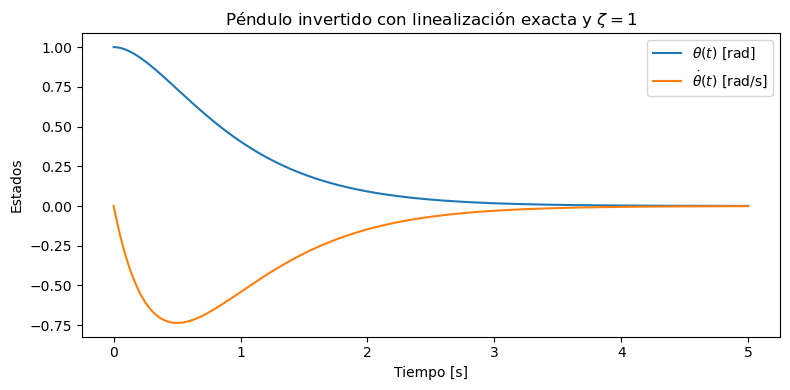

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parámetros del péndulo
g = 9.81      # gravedad [m/s^2]
l = 1.0       # longitud [m]
m = 1.0       # masa [kg]

# Controlador lineal v = -K z
# Sistema lineal: z1_dot = z2 ; z2_dot = v
# Queremos que z2_dot = -K1 z1 - K2 z2 -> ζ=1 y ωn=2 rad/s, por ejemplo
wn = 2.0
zeta = 1.0
K1 = wn**2          # ganancia proporcional
K2 = 2*zeta*wn      # ganancia derivativa

def u_exacta(x):
    """Ley de control no lineal exacta u = m*l^2*(g/l*sin(x1) - K1*x1 - K2*x2)"""
    x1, x2 = x
    v = -K1*x1 - K2*x2                # realimentación de estado en z
    u = m*l**2*((g/l)*np.sin(x1) + v) # cancelación exacta + control lineal
    return u

def f_exacta(t, x):
    x1, x2 = x
    u = u_exacta(x)
    dx1 = x2
    dx2 = -(g/l)*np.sin(x1) + (1/(m*l**2))*u
    return [dx1, dx2]

# Condiciones iniciales: desplazamiento angular de 1 rad (~57°)
x0 = [1, 0.0]
t_span = (0, 5)
t_eval = np.linspace(*t_span, 1000)

# Simulación
sol = solve_ivp(f_exacta, t_span, x0, t_eval=t_eval, rtol=1e-8)

# Graficamos
plt.figure(figsize=(8,4))
plt.plot(sol.t, sol.y[0], label=r'$\theta(t)$ [rad]')
plt.plot(sol.t, sol.y[1], label=r'$\dot{\theta}(t)$ [rad/s]')
plt.title('Péndulo invertido con linealización exacta y $\zeta=1$')
plt.xlabel('Tiempo [s]')
plt.ylabel('Estados')
#plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


## Comparación de la ventaja de la linealización exacta 

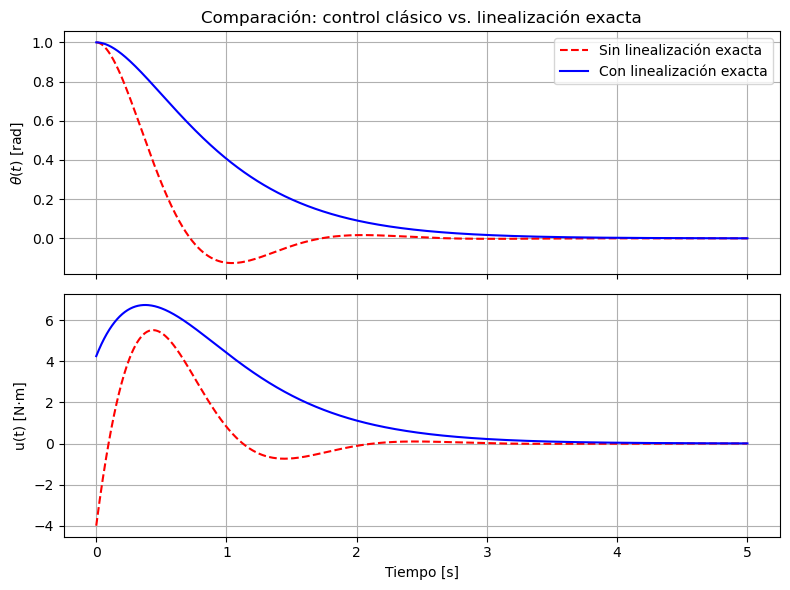

In [17]:
# --- Controladores ---
def u_lineal(x):
    """Control lineal sin cancelación de no linealidades"""
    x1, x2 = x
    return -K1*x1 - K2*x2

# --- Dinámicas ---
def f_lineal(t, x):
    x1, x2 = x
    u = u_lineal(x)
    dx1 = x2
    dx2 = -(g/l)*np.sin(x1) + (1/(m*l**2))*u
    return [dx1, dx2]

# Simulación
sol_lin = solve_ivp(f_lineal, t_span, x0, t_eval=t_eval, rtol=1e-8)

# --- Calcular u(t) para ambos casos ---
u_lin = np.array([u_lineal(sol_lin.y[:, i]) for i in range(sol_lin.y.shape[1])])
u_exa = np.array([u_exacta(sol.y[:, i]) for i in range(sol.y.shape[1])])

# --- Gráficos comparativos ---
fig, axs = plt.subplots(2, 1, figsize=(8,6), sharex=True)

# Estado angular
axs[0].plot(sol_lin.t, sol_lin.y[0], 'r--', label='Sin linealización exacta')
axs[0].plot(sol.t, sol.y[0], 'b', label='Con linealización exacta')
axs[0].set_ylabel(r'$\theta(t)$ [rad]')
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Comparación: control clásico vs. linealización exacta')

# Esfuerzo de control
axs[1].plot(sol_lin.t, u_lin, 'r--')
axs[1].plot(sol.t, u_exa, 'b')
axs[1].set_ylabel('u(t) [N·m]')
axs[1].set_xlabel('Tiempo [s]')
axs[1].grid(True)

plt.tight_layout()
plt.show()
